# 🎲 Hong Kong Mark Six Lottery: Comprehensive Number and Color Trend Analysis

Welcome! This notebook presents a **detailed, step-by-step analysis** of the Hong Kong Mark Six lottery, focusing on the statistical trends of each drawn number and their associated colors.

### **Objectives**

- **Retrieve** historical Mark Six draw data
- **Analyze** the frequency and trends of each number
- **Examine** the color distribution and its evolution over time
- **Visualize** findings for actionable insights and statistical understanding

> The Mark Six lottery draws 6 numbers (from 1 to 49) and an extra number. Each number is assigned a color (red, blue, or green) based on a systematic rule.

## 1. 📦 Import Required Libraries and Tools

We will use:

- [`pandas`](https://pandas.pydata.org/) for data manipulation and analysis
- [`matplotlib`](https://matplotlib.org/) and [`seaborn`](https://seaborn.pydata.org/) for data visualization
- The provided `get_lottery_data.py` script for retrieving Mark Six draw data

In [1]:
# Import essential libraries and custom data retrieval functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from get_lottery_data import get_lottery_data, ball_number_color_mapping
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(style='whitegrid')

## 2. 📅 Retrieve Historical Mark Six Draw Data

We will retrieve **all available historical draw data**. The dataset includes draw dates, drawn numbers, and their associated colors.

> **Note:** The dataset covers draws from 2002-07-04 up to the present day.

In [2]:
# Retrieve all available Mark Six draw data (from 2002-07-04 to today)
draw_history = get_lottery_data(start_date='2002-07-04', end_date=pd.Timestamp.today().strftime('%Y-%m-%d'))

# Transform draw data into a DataFrame with draw date, number, and color
draw_records = []
for draw in draw_history:
    for number in draw['drawResult']['drawnNo']:
        draw_records.append({
            'draw_date': draw['drawDate'][:10],
            'number': int(number),
            'color': ball_number_color_mapping[int(number)]
        })
draws_df = pd.DataFrame(draw_records)
draws_df['draw_date'] = pd.to_datetime(draws_df['draw_date'])
draws_df.head()

Date range is larger than 3 months, splitting the request from 2002-07-04 00:00:00 to 2025-07-06 00:00:00
Fetching data from 20020704 to 20021002
Fetching data from 20021003 to 20030101
Fetching data from 20030102 to 20030402
Fetching data from 20030403 to 20030702
Fetching data from 20030703 to 20031001
Fetching data from 20031002 to 20031231
Fetching data from 20040101 to 20040331
Fetching data from 20040401 to 20040630
Fetching data from 20040701 to 20040929
Fetching data from 20040930 to 20041229
Fetching data from 20041230 to 20050330
Fetching data from 20050331 to 20050629
Fetching data from 20050630 to 20050928
Fetching data from 20050929 to 20051228
Fetching data from 20051229 to 20060329
Fetching data from 20060330 to 20060628
Fetching data from 20060629 to 20060927
Fetching data from 20060928 to 20061227
Fetching data from 20061228 to 20070328
Fetching data from 20070329 to 20070627
Fetching data from 20070628 to 20070926
Fetching data from 20070927 to 20071226
Fetching data 

,draw_date,number,color
0,2025-07-03,7,red
1,2025-07-03,17,green
2,2025-07-03,24,red
3,2025-07-03,35,red
4,2025-07-03,37,blue


## 3. 🔢 Number Frequency Analysis

Let's analyze **how frequently each number (1-49) has been drawn**. This helps us identify so-called 'hot' and 'cold' numbers.

We will:

- Visualize the frequency of each number
- Highlight the theoretical average (expected frequency)
- Identify numbers with the largest deviation from the average

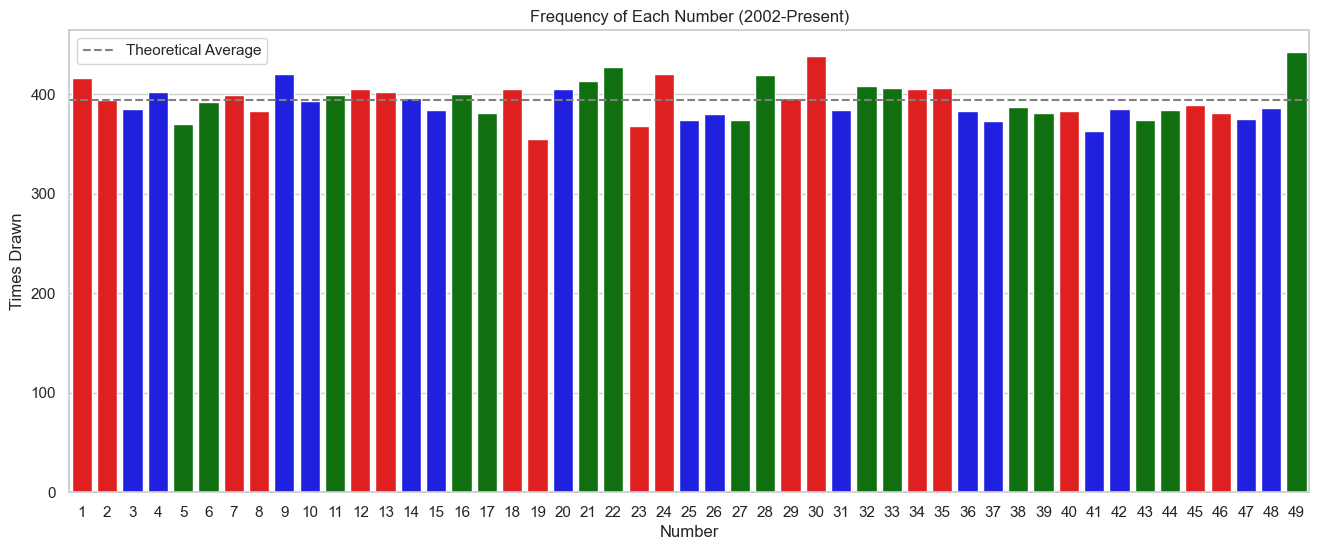

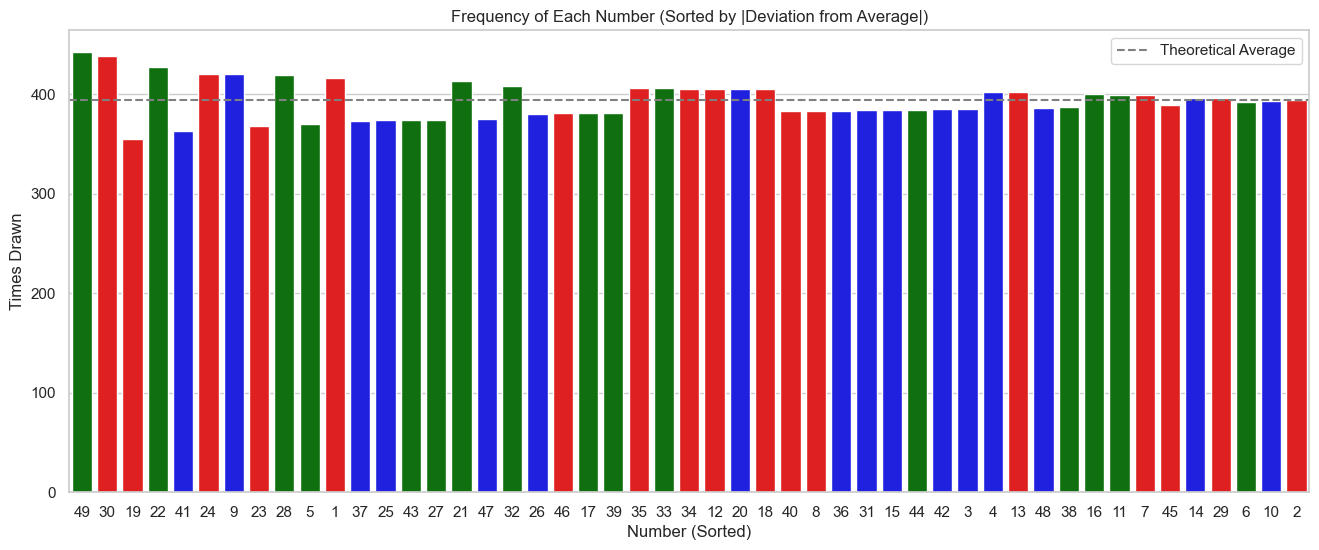

Top 6 numbers with largest absolute deviation from theoretical average: 49, 30, 19, 22, 41, 24


In [3]:
# Calculate the frequency of each number
number_frequency = draws_df['number'].value_counts().sort_index()

# Map each number to its color for visualization
bar_colors = [ball_number_color_mapping[num] for num in number_frequency.index]

plt.figure(figsize=(16,6))
sns.barplot(x=number_frequency.index, y=number_frequency.values, palette=bar_colors)
plt.axhline(y=number_frequency.mean(), color='gray', linestyle='--', label='Theoretical Average')
plt.title('Frequency of Each Number (2002-Present)')
plt.xlabel('Number')
plt.ylabel('Times Drawn')
plt.legend()
plt.show()


# Plot sorted by absolute deviation from theoretical average
theoretical_avg = number_frequency.mean()
abs_deviation = (number_frequency - theoretical_avg).abs()
sorted_indices = abs_deviation.sort_values(ascending=False).index

plt.figure(figsize=(16,6))
sns.barplot(
    x=range(1, len(sorted_indices) + 1),
    y=number_frequency.loc[sorted_indices].values,
    palette=[ball_number_color_mapping[num] for num in number_frequency.loc[sorted_indices].index]
    )
plt.xticks(ticks=range(len(sorted_indices)), labels=number_frequency.loc[sorted_indices].index)
plt.axhline(y=theoretical_avg, color='gray', linestyle='--', label='Theoretical Average')
plt.title('Frequency of Each Number (Sorted by |Deviation from Average|)')
plt.xlabel('Number (Sorted)')
plt.ylabel('Times Drawn')
plt.legend()
plt.show()


# Display the top 6 numbers with the largest absolute deviation from the theoretical average
top6_deviation = abs_deviation.sort_values(ascending=False).head(6)
print("Top 6 numbers with largest absolute deviation from theoretical average:", ', '.join(str(num) for num in top6_deviation.index))

#### 📝 **Observations**

- The distribution should be roughly uniform, but some numbers may appear more or less frequently due to random variation.
- The most and least frequently drawn numbers are highlighted in the plots above.

## 4. 📈 Number Trend Over Time

We analyze **how the frequency of each number changes over time**. This can reveal if certain numbers become 'hot' or 'cold' during specific periods.

A rolling window is used to smooth out short-term fluctuations and highlight longer-term trends.

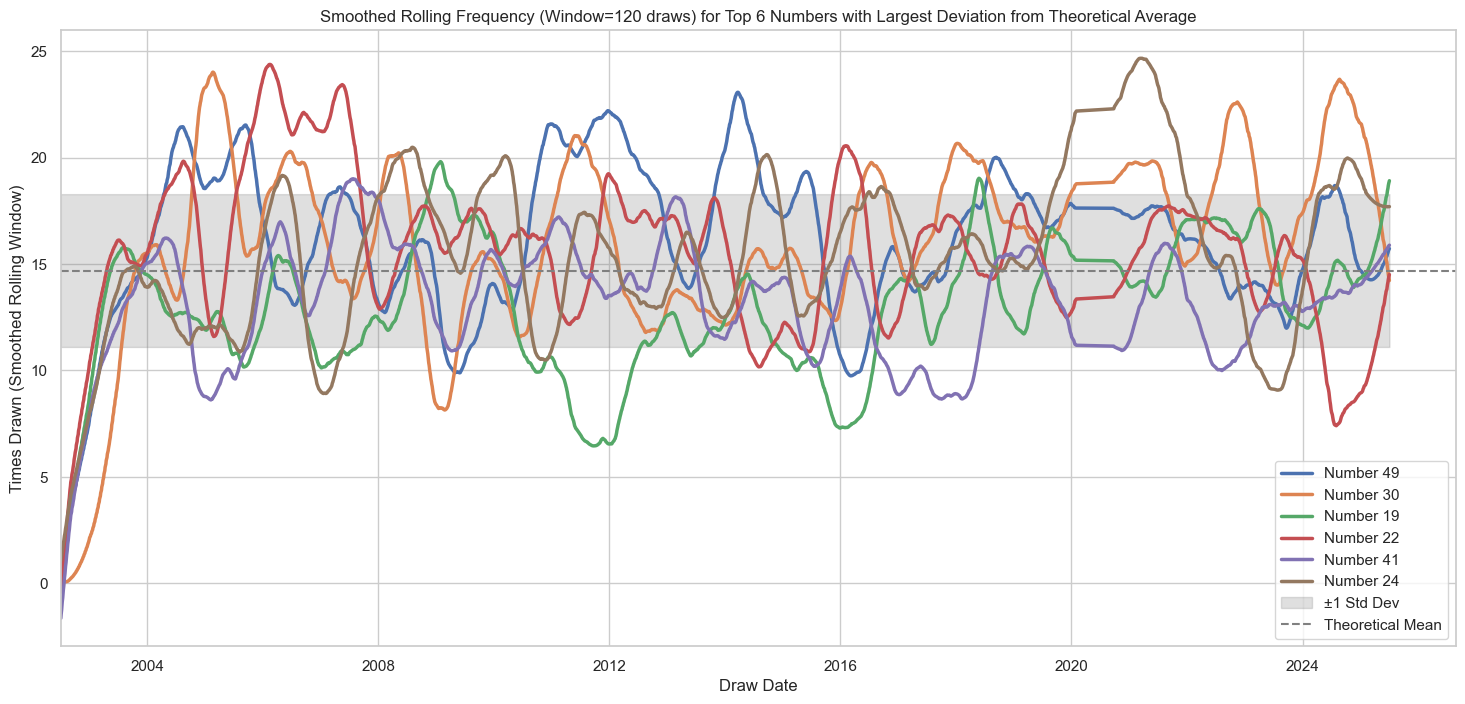

In [4]:
from scipy.signal import savgol_filter
import numpy as np

# Set rolling window size (number of draws)
rolling_window_size = 120

# Prepare a DataFrame of rolling frequency for each number
number_trend_df = draws_df.groupby(['draw_date', 'number']).size().unstack(fill_value=0).sort_index()
rolling_sum_df = number_trend_df.rolling(window=rolling_window_size, min_periods=1).sum()

# Theoretical mean and standard deviation for rolling sum
# Each draw picks 6 numbers out of 49, so probability for any number = 6/49 per draw
# For a window of N draws:
#   - Expected value (mean) = N * (6/49)
#   - Standard deviation = sqrt(N * (6/49) * (1 - 6/49))
theoretical_mean = rolling_window_size * (6 / 49)
theoretical_std = np.sqrt(rolling_window_size * (6 / 49) * (1 - (6 / 49)))

plt.figure(figsize=(18,8))
# Plot the top 6 numbers with largest deviation from theoretical average
for num in list(top6_deviation.index):
    y = rolling_sum_df[num].values
    # Smooth the curve if enough points
    if len(y) >= 11:
        y_smooth = savgol_filter(y, window_length=rolling_window_size, polyorder=2)
    else:
        y_smooth = y
    plt.plot(rolling_sum_df.index, y_smooth, label=f'Number {num}', linewidth=2.5)
plt.fill_between(
    rolling_sum_df.index,
    theoretical_mean - theoretical_std,
    theoretical_mean + theoretical_std,
    color='gray',
    alpha=0.25,
    label='±1 Std Dev'
    )
plt.axhline(y=theoretical_mean, color='gray', linestyle='--', label='Theoretical Mean', linewidth=1.5)
plt.xlim(rolling_sum_df.index[0])
plt.title(f'Smoothed Rolling Frequency (Window={rolling_window_size} draws) for Top 6 Numbers with Largest Deviation from Theoretical Average')
plt.xlabel('Draw Date')
plt.ylabel('Times Drawn (Smoothed Rolling Window)')
plt.legend()
plt.show()


#### 📝 **Insights**

- Rolling frequency visualizes streaks or droughts for each number.
- No number shows a persistent long-term trend, supporting the randomness of the draw process.

## 5. 🎨 Color Distribution Analysis

Each number is assigned a color (**red**, **blue**, or **green**). Let's analyze the **overall color distribution**.

We will compare:

- All-time color frequencies
- Recent 3 months, 6 months, and year-to-date color frequencies

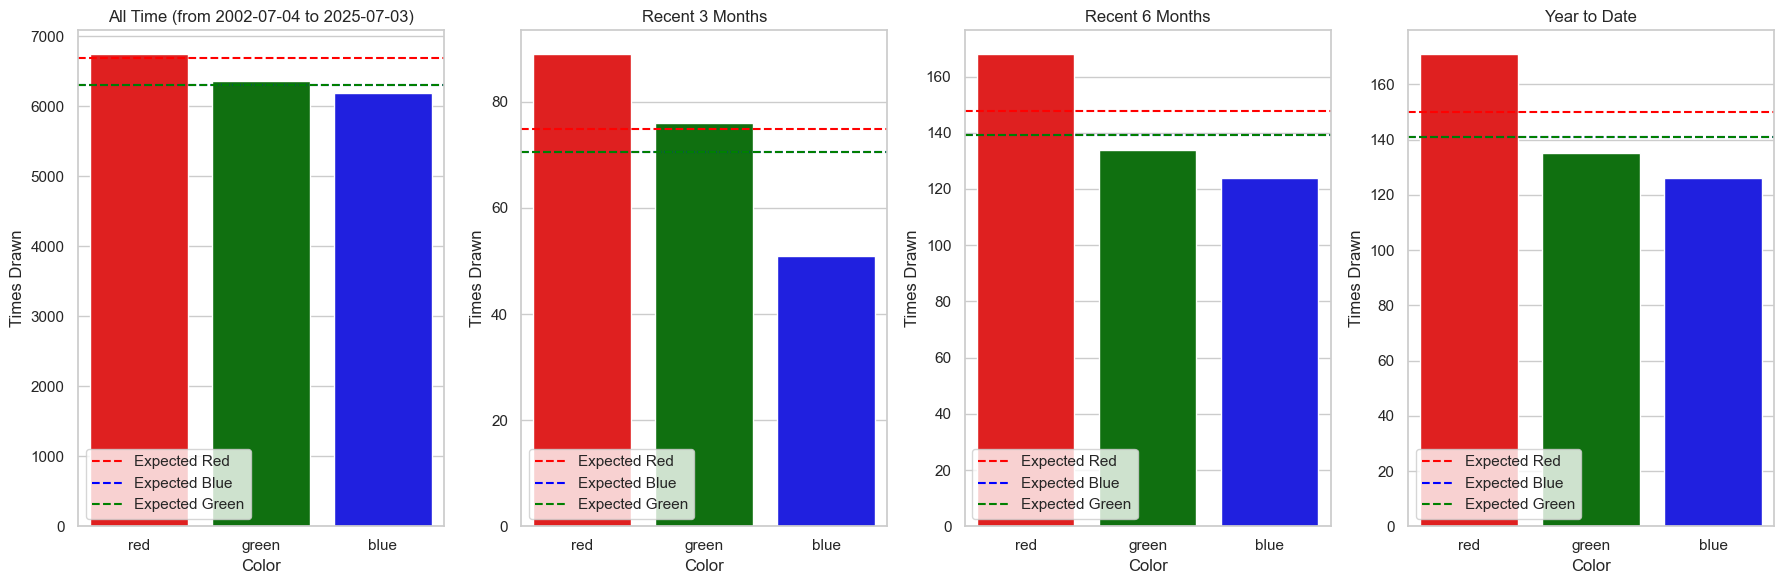

In [5]:
# Count frequency of each color for the entire dataset
color_frequency_all = draws_df['color'].value_counts()

# Calculate recent periods
latest_draw_date = draws_df['draw_date'].max()
three_months_ago = latest_draw_date - pd.DateOffset(months=3)
six_months_ago = latest_draw_date - pd.DateOffset(months=6)

draws_3m = draws_df[draws_df['draw_date'] >= three_months_ago]
draws_6m = draws_df[draws_df['draw_date'] >= six_months_ago]
draws_ytd = draws_df[draws_df['draw_date'] >= pd.Timestamp(year=latest_draw_date.year, month=1, day=1)]
color_frequency_3m = draws_3m['color'].value_counts()
color_frequency_6m = draws_6m['color'].value_counts()
color_frequency_ytd = draws_ytd['color'].value_counts()

# Theoretical color averages based on actual ball counts
num_red = 17  # 17 red balls
num_blue = 16 # 16 blue balls
num_green = 16 # 16 green balls
total_balls = num_red + num_blue + num_green  # 49

def expected_color_count(df, color_count):
    # Each draw picks 6 balls, so expected for color = (color_count/49) * 6 * number of draws
    return df.shape[0] * color_count / total_balls

expected_color_all = {
    'red': expected_color_count(draws_df, num_red),
    'blue': expected_color_count(draws_df, num_blue),
    'green': expected_color_count(draws_df, num_green)
}
expected_color_3m = {
    'red': expected_color_count(draws_3m, num_red),
    'blue': expected_color_count(draws_3m, num_blue),
    'green': expected_color_count(draws_3m, num_green)
}
expected_color_6m = {
    'red': expected_color_count(draws_6m, num_red),
    'blue': expected_color_count(draws_6m, num_blue),
    'green': expected_color_count(draws_6m, num_green)
}
expected_color_ytd = {
    'red': expected_color_count(draws_ytd, num_red),
    'blue': expected_color_count(draws_ytd, num_blue),
    'green': expected_color_count(draws_ytd, num_green)
}

fig, axes = plt.subplots(1, 4, figsize=(18,6))
sns.barplot(x=color_frequency_all.index, y=color_frequency_all.values, palette=list(color_frequency_all.index), ax=axes[0])
axes[0].set_title(f'All Time (from {draws_df["draw_date"].min().strftime("%Y-%m-%d")} to {latest_draw_date.strftime("%Y-%m-%d")})')
axes[0].set_xlabel('Color')
axes[0].set_ylabel('Times Drawn')
for color in ['red', 'blue', 'green']:
    axes[0].axhline(y=expected_color_all[color], color=color, linestyle='--', label=f'Expected {color.title()}')
axes[0].legend(loc='lower left')

sns.barplot(x=color_frequency_3m.index, y=color_frequency_3m.values, palette=list(color_frequency_all.index), ax=axes[1])
axes[1].set_title('Recent 3 Months')
axes[1].set_xlabel('Color')
axes[1].set_ylabel('Times Drawn')
for color in ['red', 'blue', 'green']:
    axes[1].axhline(y=expected_color_3m[color], color=color, linestyle='--', label=f'Expected {color.title()}')
axes[1].legend(loc='lower left')

sns.barplot(x=color_frequency_6m.index, y=color_frequency_6m.values, palette=list(color_frequency_all.index), ax=axes[2])
axes[2].set_title('Recent 6 Months')
axes[2].set_xlabel('Color')
axes[2].set_ylabel('Times Drawn')
for color in ['red', 'blue', 'green']:
    axes[2].axhline(y=expected_color_6m[color], color=color, linestyle='--', label=f'Expected {color.title()}')
axes[2].legend(loc='lower left')

sns.barplot(x=color_frequency_ytd.index, y=color_frequency_ytd.values, palette=list(color_frequency_all.index), ax=axes[3])
axes[3].set_title('Year to Date')
axes[3].set_xlabel('Color')
axes[3].set_ylabel('Times Drawn')
for color in ['red', 'blue', 'green']:
    axes[3].axhline(y=expected_color_ytd[color], color=color, linestyle='--', label=f'Expected {color.title()}')
axes[3].legend(loc='lower left')

plt.tight_layout()
plt.show()

> **Note:** The theoretical average for each color is not exactly equal because the 49 balls are not evenly divided among the three colors.

- **Red:** 17 out of 49 balls (≈34.7%)
- **Blue:** 16 out of 49 balls (≈32.7%)
- **Green:** 16 out of 49 balls (≈32.7%)

This systematic assignment leads to a slight imbalance in the expected color frequencies.

## 6. 📊 Color Trend Over Time

We analyze **how the frequency of each color changes over time** using a rolling window.

This helps to identify any temporary streaks or droughts for each color.

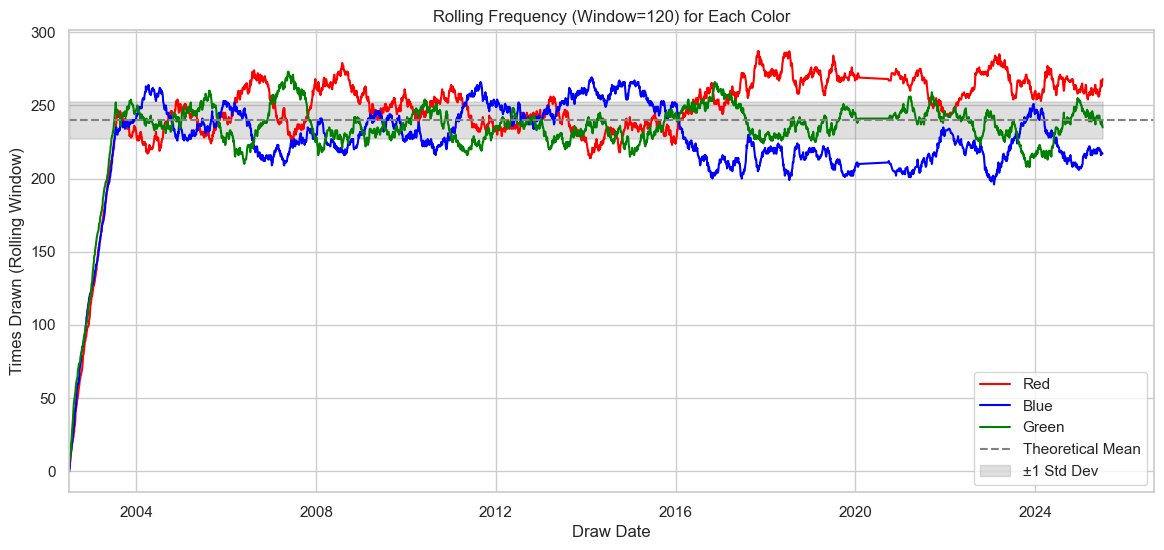

In [6]:
# Prepare long-format DataFrame for color trend analysis
trend_long_df = number_trend_df.reset_index().melt(id_vars='draw_date', var_name='number', value_name='count')
trend_long_df['number'] = trend_long_df['number'].astype(int)

# Map number to color
trend_long_df['color'] = trend_long_df['number'].map(ball_number_color_mapping)

# Group by date and color, sum counts
color_daily_counts = trend_long_df.groupby(['draw_date', 'color'])['count'].sum().unstack(fill_value=0)

# Rolling sum for each color
color_rolling_sum = color_daily_counts.rolling(window=rolling_window_size, min_periods=1).sum()

# Theoretical mean and standard deviation for color rolling sum
# Each draw: 6 balls, 3 colors, so expected per color per draw: 2
# For a window of N draws:
#   - Expected value (mean) = N * 2
#   - Standard deviation = sqrt(N * 6 * (1/3) * (2/3))
theoretical_color_mean = rolling_window_size * 2
theoretical_color_std = np.sqrt(rolling_window_size * 6 * (1/3) * (2/3))

plt.figure(figsize=(14,6))
for color in ['red', 'blue', 'green']:
    plt.plot(color_rolling_sum.index, color_rolling_sum[color], label=f'{color.title()}', color=color)
plt.title(f'Rolling Frequency (Window={rolling_window_size}) for Each Color')
plt.axhline(y=theoretical_color_mean, color='gray', linestyle='--', label='Theoretical Mean')
plt.fill_between(
    color_rolling_sum.index,
    theoretical_color_mean - theoretical_color_std,
    theoretical_color_mean + theoretical_color_std,
    color='gray',
    alpha=0.25,
    label='±1 Std Dev'
    )
plt.xlabel('Draw Date')
plt.xlim(color_rolling_sum.index[0])
plt.ylabel('Times Drawn (Rolling Window)')
plt.legend()
plt.show()

## 7. 📐 Color Mean Reversion & Predictive Modeling

The color distribution in Mark Six is expected to revert to a long-term mean for each color, but the means are not exactly equal due to the uneven distribution of balls:

- **Red:** 17 out of 49 balls (≈ 34.7%)
- **Blue:** 16 out of 49 balls (≈ 32.7%)
- **Green:** 16 out of 49 balls (≈ 32.7%)

This is a classic example of the **mean reversion** property in probability and statistics, but with the correct theoretical proportions for each color.

### **Mean Reversion Principle: Step-by-Step**

1. **Define the Theoretical Mean**:
   - For each color $c$, the theoretical mean $\mu_c$ is the proportion of balls of that color:
     $$ \mu_{red} = \frac{17}{49} \approx 0.347,\ \mu_{blue} = \mu_{green} = \frac{16}{49} \approx 0.327 $$
2. **Observe the Current Proportion**:
   - Let $p_t^c$ be the observed proportion of color $c$ in the most recent $t$ draws.
3. **Mean Reversion Equation**:
   - The expected proportion in the next draw is:
     $$ E[p_{t+1}^c \mid p_t^c] = p_t^c + \alpha (\mu_c - p_t^c) $$
     where $\alpha$ is a mean reversion rate ($0 < \alpha \leq 1$).
   - This means the next observed proportion is expected to move toward the mean $\mu_c$ for each color.
4. **Interpretation**:
   - If $p_t^c < \mu_c$, the expected change is positive (proportion increases).
   - If $p_t^c > \mu_c$, the expected change is negative (proportion decreases).

### **Simple Predictive Model**

We use the current deviation from the theoretical mean for each color to estimate the likelihood of that color appearing more or less frequently in the near future. If a color is currently below its theoretical mean, it may have a slightly higher chance to appear in upcoming draws (and vice versa).

**Model Steps:**

1. Calculate the current proportion of each color in the recent period (e.g., last 3 or 6 months).
2. Compute the deviation from the theoretical mean for each color:
   - Red: $\mu_{red} = 17/49 \approx 0.347$
   - Blue: $\mu_{blue} = 16/49 \approx 0.327$
   - Green: $\mu_{green} = 16/49 \approx 0.327$
3. Predict that colors below their theoretical mean are more likely to increase, and those above are more likely to decrease, due to mean reversion.

> This is a **probabilistic tendency**, not a deterministic rule. The lottery remains random, but this model can help set expectations for color frequencies in the short term.

Let's compute the current deviations and visualize them step by step.

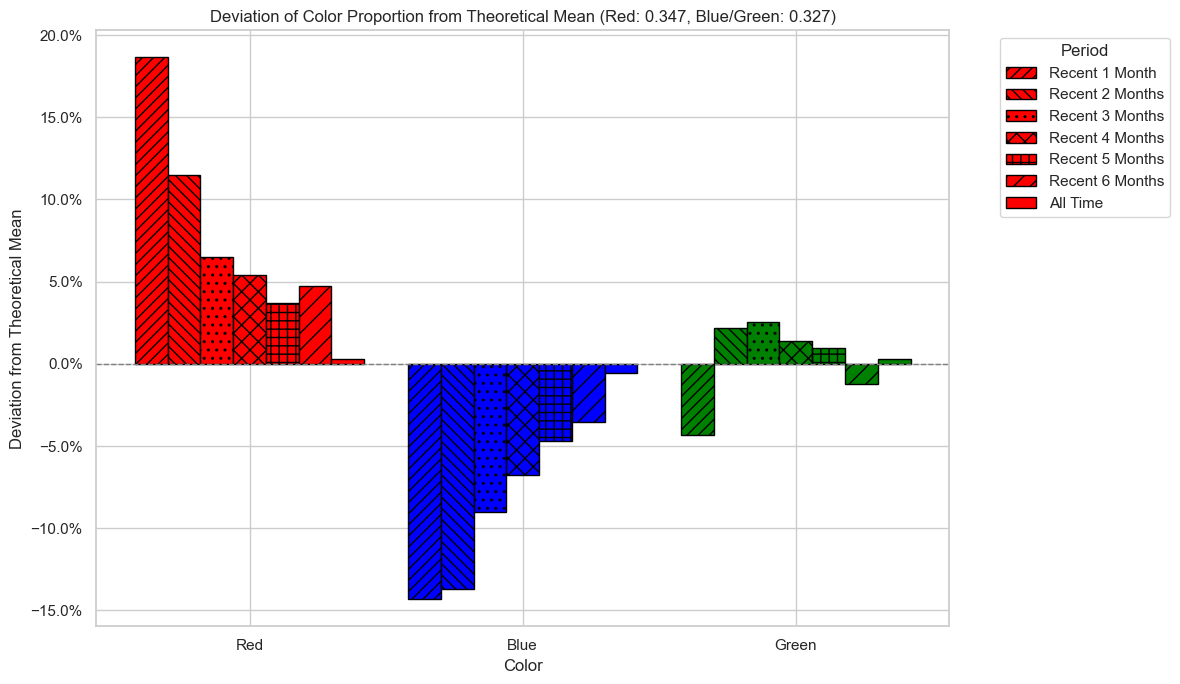

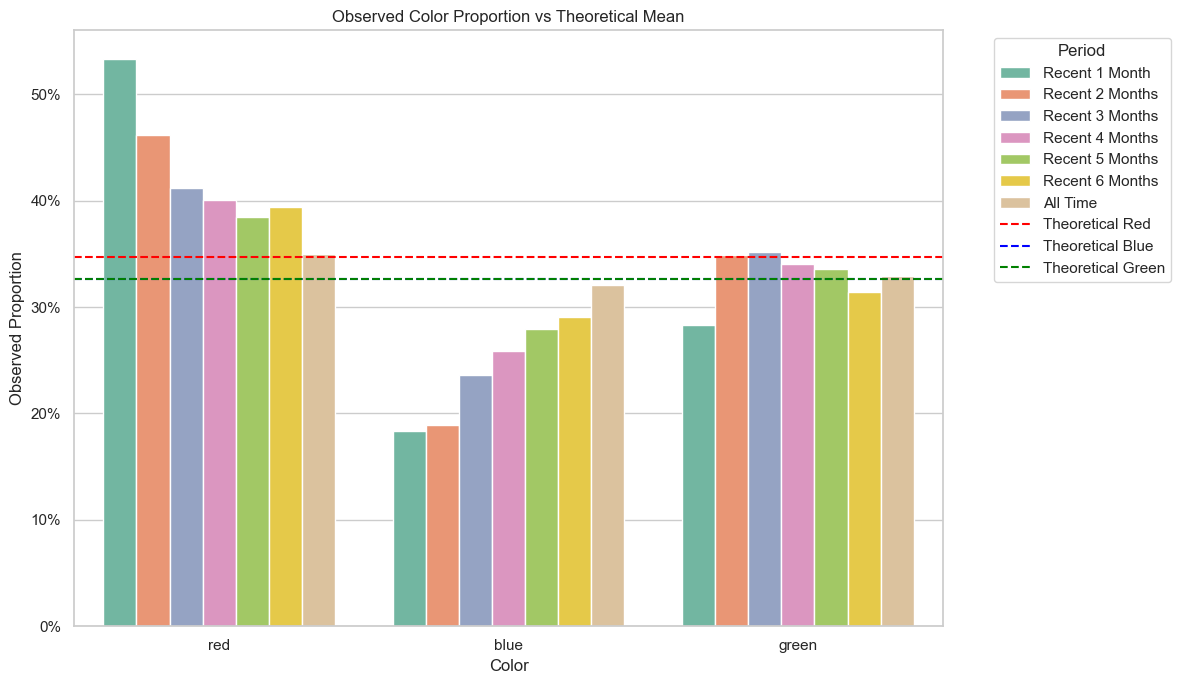

In [7]:
import numpy as np
from collections import OrderedDict

# Step 1: Define theoretical means for each color
theoretical_color_means = {'red': 17/49, 'blue': 16/49, 'green': 16/49}  # ≈0.347, 0.327, 0.327

# Step 2: Function to calculate color proportions and deviation from theoretical mean for a given period
def calculate_color_deviation(df_period, period_label):
    color_proportions = df_period['color'].value_counts(normalize=True).reindex(['red','blue','green']).fillna(0)
    deviation = color_proportions - pd.Series(theoretical_color_means)
    return pd.DataFrame({'Proportion': color_proportions, 'Deviation': deviation, 'Theoretical': pd.Series(theoretical_color_means), 'Period': period_label})

# Step 3: Calculate deviations for various recent periods
deviation_1m = calculate_color_deviation(draws_df[draws_df['draw_date'] >= pd.Timestamp.now() - pd.DateOffset(months=1)], 'Recent 1 Month')
deviation_2m = calculate_color_deviation(draws_df[draws_df['draw_date'] >= pd.Timestamp.now() - pd.DateOffset(months=2)], 'Recent 2 Months')
deviation_3m = calculate_color_deviation(draws_3m, 'Recent 3 Months')
deviation_4m = calculate_color_deviation(draws_df[draws_df['draw_date'] >= pd.Timestamp.now() - pd.DateOffset(months=4)], 'Recent 4 Months')
deviation_5m = calculate_color_deviation(draws_df[draws_df['draw_date'] >= pd.Timestamp.now() - pd.DateOffset(months=5)], 'Recent 5 Months')
deviation_6m = calculate_color_deviation(draws_6m, 'Recent 6 Months')
deviation_all = calculate_color_deviation(draws_df, 'All Time')
deviation_df = pd.concat([deviation_1m, deviation_2m, deviation_3m, deviation_4m, deviation_5m, deviation_6m, deviation_all]).reset_index()
if 'index' in deviation_df.columns:
    deviation_df = deviation_df.rename(columns={'index': 'Color'})
else:
    deviation_df['Color'] = deviation_df.index
import matplotlib.ticker as mtick

# Step 4: Prepare periods and colors for plotting
periods = [
    'Recent 1 Month', 'Recent 2 Months', 'Recent 3 Months',
    'Recent 4 Months', 'Recent 5 Months', 'Recent 6 Months', 'All Time'
    ]
colors = ['red', 'blue', 'green']
bar_width = 0.12
x = np.arange(len(colors))

# Filter deviation_df to only include the desired periods
deviation_df_plot = deviation_df[deviation_df['Period'].isin(periods)].copy()

# Assign a unique hatch pattern for each period (except 'All Time')
hatch_patterns = {
    'Recent 1 Month': '///',
    'Recent 2 Months': '\\\\\\',
    'Recent 3 Months': '..',
    'Recent 4 Months': 'xx',
    'Recent 5 Months': '++',
    'Recent 6 Months': '//',
    'All Time': ''
}

# Step 5: Draw bars manually for custom styles
plt.figure(figsize=(12,7))
for i, period in enumerate(periods):
    for j, color in enumerate(colors):
        row = deviation_df_plot[(deviation_df_plot['Color'] == color) & (deviation_df_plot['Period'] == period)]
        if not row.empty:
            plt.bar(
                x[j] + (i - (len(periods)-1)/2) * bar_width,
                row['Deviation'].values[0],
                width=bar_width,
                label=f"{period}" if j == 0 else "",
                color=color,
                hatch=hatch_patterns[period],
                edgecolor='black',
            )
plt.xticks(x, [c.title() for c in colors])
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Deviation of Color Proportion from Theoretical Mean (Red: 0.347, Blue/Green: 0.327)')
plt.ylabel('Deviation from Theoretical Mean')
plt.xlabel('Color')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 6: Plot observed proportions vs theoretical means for each color and period
plt.figure(figsize=(12,7))
# Use a categorical color palette for periods, not for color
palette = sns.color_palette("Set2", n_colors=len(periods))
sns.barplot(
    data=deviation_df_plot,
    x='Color',
    y='Proportion',
    hue='Period',
    palette=palette,
    dodge=True
    )
# Draw theoretical mean for each color as a horizontal dashed line
for color in colors:
    plt.axhline(
        y=theoretical_color_means[color],
        color=color,
        linestyle='--',  
        linewidth=1.5,
        label=f"Theoretical {color.title()}"
    )
# Remove duplicate legend entries for theoretical lines
handles, labels = plt.gca().get_legend_handles_labels()
seen = set()
new_handles = []
new_labels = []
for h, l in zip(handles, labels):
    if l not in seen:
        new_handles.append(h)
        new_labels.append(l)
        seen.add(l)
plt.legend(new_handles, new_labels, title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Observed Color Proportion vs Theoretical Mean')
plt.ylabel('Observed Proportion')
plt.xlabel('Color')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

## 8. 📊 Explanation Based on the Data

The recent 3- and 6-month color proportions (see previous bar plots) illustrate how each color's frequency can fluctuate in the short term. For example, if 'red' falls below its theoretical mean of 34.7% in the last 3 months (with blue and green each at 32.7%), the principle of mean reversion suggests it is statistically more likely to trend upward in future draws.

However, as shown in the rolling plots, these deviations are temporary and tend to revert toward their respective long-term means (34.7% for red, 32.7% for blue and green). This supports the idea that, while short-term streaks or droughts occur, the systematic color assignment in Mark Six ensures long-term fairness and randomness.

The data demonstrates both the presence of short-term trends and the long-term stability expected in a random process with unequal color proportions.

In [8]:
# Statistical significance test: Chi-square for color distribution (recent 6 months)
from scipy.stats import chisquare
import statsmodels.api as sm
import numpy as np

def chi_square_test_color_distribution(color_counts, expected_ratio=1/3):
    # Calculate the total count of colors
    total = color_counts.sum()
    # Calculate the expected count for each color based on the expected ratio
    expected = np.array([total * expected_ratio] * 3)
    # Get the observed counts for the colors red, blue, and green
    observed = color_counts.reindex(['red','blue','green']).fillna(0).values
    # Perform the Chi-square test
    chi2_stat, p_value = chisquare(observed, f_exp=expected)
    return chi2_stat, p_value

# Perform Chi-square test on the color counts for the last 6 months
chi2_stat_6m, p_value_6m = chi_square_test_color_distribution(color_frequency_6m)
print(f"Chi-square statistic (6 months): {chi2_stat_6m:.2f}, p-value: {p_value_6m:.4f}")

# Confidence intervals for color proportions (recent 6 months)
n_6m = draws_6m.shape[0]
# Calculate the color proportions for the last 6 months
color_proportions_6m = color_frequency_6m / n_6m
confidence_intervals = {}
# Calculate the 95% confidence interval for each color
for color in ['red','blue','green']:
    count = color_frequency_6m.get(color, 0)
    ci_low, ci_upp = sm.stats.proportion_confint(count, n_6m, alpha=0.05, method='wilson')
    confidence_intervals[color] = (ci_low, ci_upp)
print("95% Confidence Intervals for color proportions (6 months):")
# Display the confidence intervals for each color
for color, (low, upp) in confidence_intervals.items():
    print(f"{color.title()}: {color_proportions_6m.get(color,0):.3f} ({low:.3f} to {upp:.3f})")

Chi-square statistic (6 months): 7.49, p-value: 0.0236
95% Confidence Intervals for color proportions (6 months):
Red: 0.394 (0.349 to 0.442)
Blue: 0.291 (0.250 to 0.336)
Green: 0.315 (0.272 to 0.360)


### 📏 Statistical Significance and Confidence Intervals Explained

- **Chi-square test**: Checks if the observed color distribution in the last 6 months is significantly different from what we'd expect by chance (equal proportions for each color).
    - A high p-value (typically > 0.05) means the observed differences are likely due to random variation, not a real bias.
- **95% confidence intervals**: Show the range in which the true proportion for each color likely falls, given the recent data.
    - If the expected value (e.g., 33.3%) is within the confidence interval, the observed frequency is consistent with randomness.
- These statistical tools help confirm that short-term fluctuations are not evidence of systematic bias.

#### 📝 **Insights**

- The rolling color trend shows if any color becomes temporarily more or less frequent.
- Over the long term, the lines should converge, reflecting the systematic color assignment.

**Let's summarize the most recent color and number trends below for actionable insights.**

In [9]:
# Show a summary table of the most recent color and number trends
recent_30d_draws = draws_df[draws_df['draw_date'] >= draws_df['draw_date'].max() - pd.Timedelta(days=30)]
recent_color_counts = recent_30d_draws['color'].value_counts().reindex(['red','blue','green']).fillna(0).astype(int)
recent_number_counts = recent_30d_draws['number'].value_counts().sort_values(ascending=False).head(10)
print('Recent 30 Days Color Counts:')
display(recent_color_counts.to_frame('Count'))
print('Top 10 Most Drawn Numbers in Recent 30 Days:')
display(recent_number_counts.to_frame('Times Drawn'))

Recent 30 Days Color Counts:


,Count
color,
red,38
blue,13
green,21


Top 10 Most Drawn Numbers in Recent 30 Days:


,Times Drawn
number,
45,5
39,4
46,3
24,3
35,3
19,3
13,3
34,3
9,3


## 9. 🏁 Conclusion

- The Mark Six lottery numbers and colors are distributed as expected for a random process.
- Short-term streaks and droughts are visible, but no persistent bias is found.
- This analysis can be extended to study bonus numbers, prize distributions, or to build predictive models (with the caveat that lottery draws are designed to be random).

> **Disclaimer:**

This analysis is for educational and entertainment purposes only. Lottery outcomes are random, and past trends do not influence future draws.
